In [1]:
%matplotlib notebook
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt


from nansat import Nansat, Domain, Nansatmap
from nansat.nsr import NSR

In [2]:
# GLOBCURRENT data at IFREMER: total surface current
CURRENT_DATA_SOURCE = 'http://tds0.ifremer.fr/thredds/dodsC/CLS-L4-CUREUL_HS-ALT_SUM-V02.0_FULL_TIME_SERIE'
# OC CCI data at PML: surface chlorophyll-a concentration
CHL_DATA_SOURCE = 'https://www.oceancolour.org/thredds/dodsC/CCI_ALL-v3.0-DAILY'
DATE = '2010-05-06'

In [3]:
# resolution (m)
res = 4000
# region of interest: Gulfstream
dom = Domain(NSR().wkt, '-te -80 25 -60 45 -tr 0.125 0.125')

In [4]:
# Connect to PML
chln = Nansat(CHL_DATA_SOURCE, bands=['chlor_a'], date=DATE)
# Change projection
chln.reproject(dom)
# Get Chlorophyll-A data
chl = chln[1]

/home/vagrant/miniconda/lib/python2.7/site-packages/nansat/mappers/opendap.py:89: UserWarning: Time consuming loading time from OpenDAP...
  warnings.warn('Time consuming loading time from OpenDAP...')
/home/vagrant/miniconda/lib/python2.7/site-packages/nansat/mappers/opendap.py:91: UserWarning: Loading time - OK!
  warnings.warn('Loading time - OK!')


In [5]:
# connect to IFREMER
ngc = Nansat(CURRENT_DATA_SOURCE, date=DATE,
                bands=['eastward_eulerian_current_velocity',
                       'northward_eulerian_current_velocity'])
# change projection
ngc.reproject(dom)

In [6]:
# Get Eulerian current from GlobCurrent dataset
u = ngc['eastward_eulerian_current_velocity']
v = ngc['northward_eulerian_current_velocity']

<IPython.core.display.Javascript object>


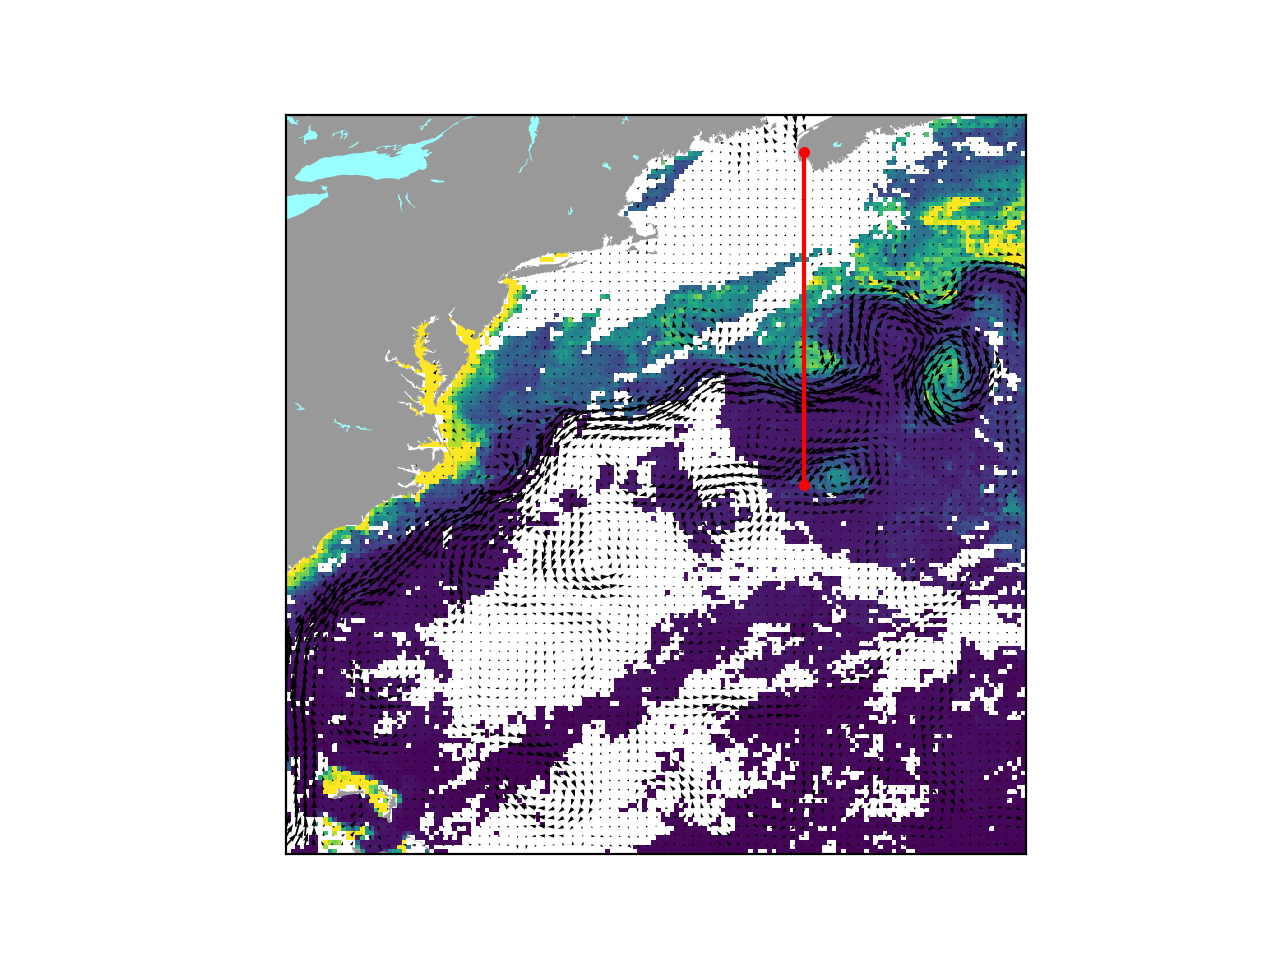

/home/vagrant/miniconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3310: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/vagrant/miniconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3319: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/vagrant/miniconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3729: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/vagrant/miniconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3738: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/vagrant/miniconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3274: MatplotlibD

In [7]:
# create simplistic map including chlorophyll at background and current shown by vectors
# transect (used below) shown by red line
plt.close('all')
nmap = Nansatmap(dom, resolution='i')
nmap.imshow(chl, vmax=1.5)
nmap.quiver(u, v, step=2)
x,y = nmap([-66, -66], [35, 44])
nmap.plot(x, y, 'r.-')
nmap.save('gc_example.png', dpi=300)

In [8]:
# select dates for querying GC data (30 days starting from 1 May 2010)
date0 = dt.datetime(2010,5,1)
days = 30
dates = [(date0 + dt.timedelta(day)).strftime('%Y-%m-%d')
         for day in range(days)]

In [9]:
# container for U
uu = []
# loop over dates
for date in dates:
    print '.',
    # access IFREMER
    n = Nansat(CURRENT_DATA_SOURCE,
                 date=date,
                 bands=['eastward_eulerian_current_velocity'])
    # crop to transect region
    n.crop_lonlat([-67, -65], [34, 45])
    # get data from transect
    trn = n.get_transect([[-66, -66], [35, 44]], bands=[1])
    # add data to the container
    uu.append(trn['eastward_eulerian_current_velocity'])

.

/home/vagrant/miniconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


<IPython.core.display.Javascript object>


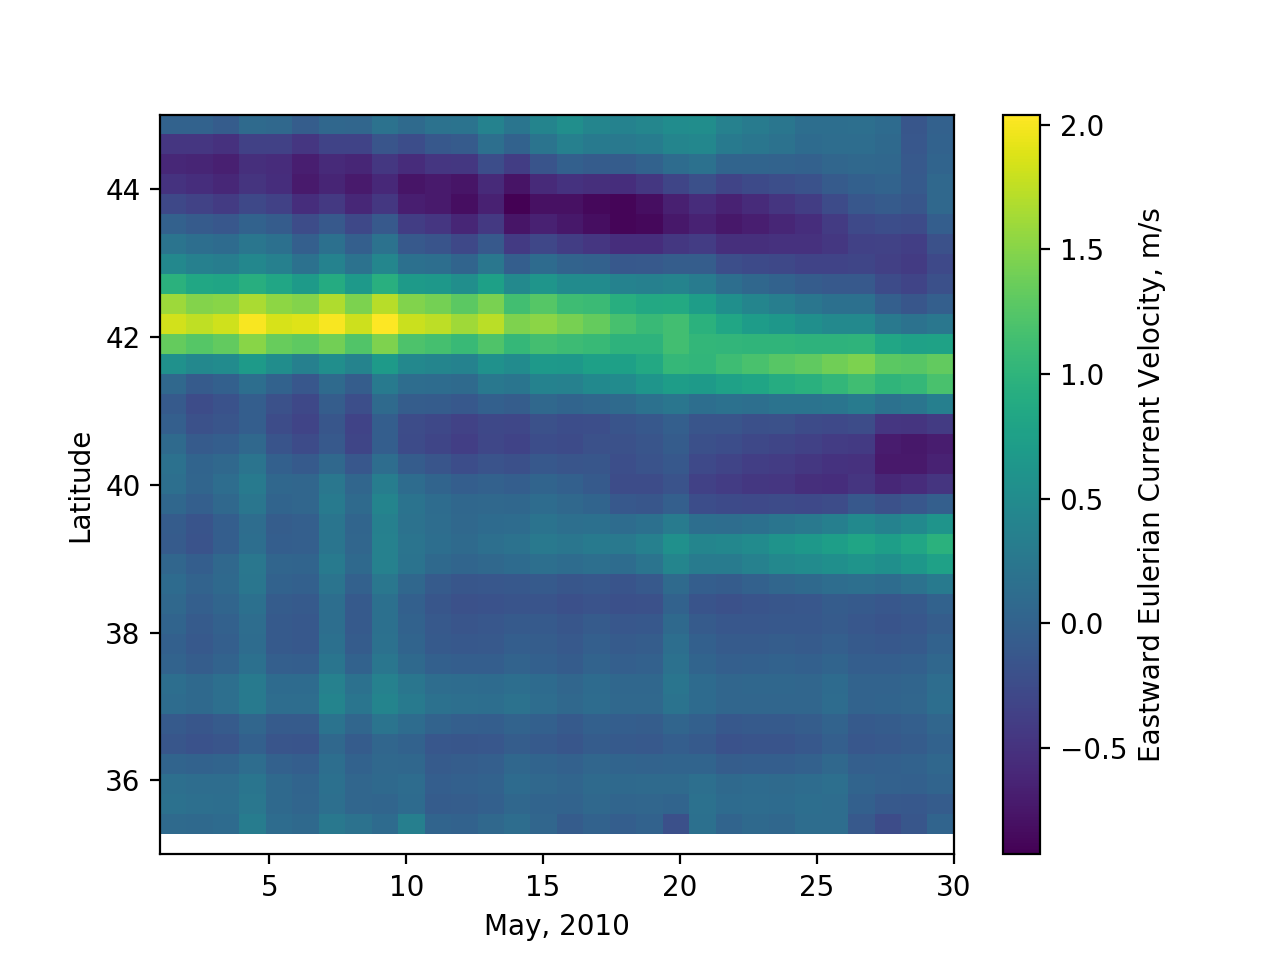

In [10]:
plt.figure()
plt.imshow(np.array(uu).T, extent=[1,30,35,45],aspect='auto')
plt.xlabel('May, 2010')
plt.ylabel('Latitude')
cbar = plt.colorbar()
cbar.set_label('Eastward Eulerian Current Velocity, m/s')